In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import string
import nltk
import re
import seaborn as sns

# Preprocess

In [ ]:
file_path = 'tiki_sentiment/preprocess_data.json'
df = pd.read_json(file_path, orient='records')
df = df.drop(['ttn_tieu_de', 'ttn_mieu_ta', 'url', 'domain_type'], axis=1)
df.head(3)

In [10]:
file_path = 'tiki_sentiment/preprocessed_data.csv'
df = pd.read_csv(file_path)
df.head(3)

,Unnamed: 0,ttn_gia,ttn_bl_diem,ttn_bl_noi_dung,ttn_thuong_hieu
0,0,45.000,5,chất lượng sản phẩm tuyệt vời,No Brand
1,1,255.000,4,"chất lượng sản phẩm tuyệt vời, chất lượng sản ...",No Brand
2,2,105.000,5,chất lượng sản phẩm tuyệt vời đóng gói sản phẩ...,No Brand


In [5]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

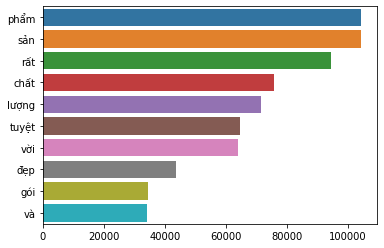

In [16]:
# clean text
top_bi_bigrams=get_top_ngram(df['ttn_bl_noi_dung'],1)
x2,y2=map(list,zip(*top_bi_bigrams))
sns.barplot(x=y2,y=x2)

In [3]:
df.shape

(10066, 4)

In [ ]:
# initialize dicts and functions
STOP_WORDS = []
with open('vocab/vietnamese_stopwords.txt', 'r', encoding='UTF-8') as f:
    lines = f.read().splitlines()
    STOP_WORDS.append(lines)

ACRONYMS = {}
with open('vocab/acronym.txt', 'r', encoding='UTF-8') as f:
    lines = f.read().splitlines()
    for line in lines:
        text = line.split(',')[0]
        text_acronym = line.split(',')[1]
        ACRONYMS[text] = text_acronym
        
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOP_WORDS])
        
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_moneysign(text):
    return text.translate(str.maketrans('', '', '₫'))

def replace_with_acronym(text):
    if (text in ACRONYMS):
        return ACRONYMS[text]
    return text

def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)
    
# get mean of bl_diem array
df['ttn_bl_diem'] = df['ttn_bl_diem'].apply( lambda sentiment_array: 
                    int(np.mean([int(sentiment) for sentiment in sentiment_array])))

# reduce vietnamdong sign
df['ttn_gia'] = df['ttn_gia'].apply( lambda value: remove_moneysign(value))

# replace nan values with 0
df['ttn_thuong_hieu'] = df['ttn_thuong_hieu'].replace(np.nan, 0)

# to lowercase
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply( lambda comment_array: 
                    [comment.lower() for comment in comment_array])
# remove punctuations
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: 
                    [remove_punctuation(comment) for comment in comment_array])

# remove stopwords
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: 
                    [remove_stopwords(comment) for comment in comment_array])

# remove stopwords
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: 
                    [remove_stopwords(comment) for comment in comment_array])

# replace words with acronyms
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: 
                    [replace_with_acronym(comment) for comment in comment_array])

# # replace emoticons with english words
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: 
                    [convert_emoticons(comment) for comment in comment_array])

# maybe join comment array to a huge string 
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment_array: ', '.join([str(x) for x in comment_array]) )


In [63]:
import emoji
import functools
import operator

# split_emoji sticking to other words
def split_emoji(em):
    em_split_emoji = emoji.get_emoji_regexp().split(em)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    return ' '.join(em_split)
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment: convert_emoticons(comment))

# replace emoticons with english words
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment: emoji.demojize(comment))

In [23]:
# remove duplicated first character and last character
def remove_duplicate_character(text):
    prev_c = '%'
    result = ''
    for c in text:
        if (prev_c != c):
            result += c
            prev_c = c
    return result
df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda comment: remove_duplicate_character(comment))

In [ ]:
from collections import Counter
cnt = Counter()
for text in df["ttn_bl_noi_dung"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common()[:-1000:-1]

In [ ]:
# remove uncommon words
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df['ttn_bl_noi_dung'] = df['ttn_bl_noi_dung'].apply(lambda word: remove_rarewords(word))

In [66]:
df.to_csv('tiki_sentiment/preprocessed_data.csv')

In [113]:
df['ttn_bl_diem'].value_counts(sort=False)/len(df['ttn_bl_diem']) * 100

5    47.913769
4    45.161931
2     0.675541
3     5.364594
1     0.884165
Name: ttn_bl_diem, dtype: float64

Text(0, 0.5, 'Label')

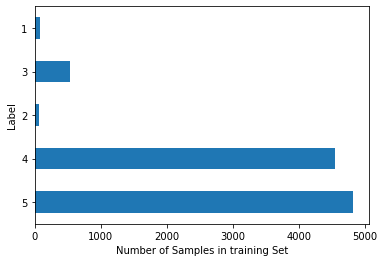

In [108]:
ax = df['ttn_bl_diem'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('Label')

# Visualization

In [2]:
df = pd.read_csv('tiki_sentiment/preprocessed_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.head(3)

,ttn_gia,ttn_bl_diem,ttn_bl_noi_dung,ttn_thuong_hieu
0,45.000,5,chất lượng sản phẩm tuyệt vời,No Brand
1,255.000,4,"chất lượng sản phẩm tuyệt vời, chất lượng sản ...",No Brand
2,105.000,5,chất lượng sản phẩm tuyệt vời đóng gói sản phẩ...,No Brand


## Wordcloud

In [ ]:
review = df[df.ttn_bl_diem == 1]
review = df[df.ttn_bl_diem == 2]
review = df[df.ttn_bl_diem == 3]
review = df[df.ttn_bl_diem == 4]
review = df[df.ttn_bl_diem == 5]

In [ ]:
review_string = []
for t in review.ttn_bl_noi_dung:
    review_string.append(t)
review_string = pd.Series(review_string).str.cat(sep=' ')

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(review_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## CountVectorizer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
cvec = CountVectorizer()
cvec.fit(df.ttn_bl_noi_dung)

neg_doc_matrix = cvec.transform(df[df.ttn_bl_diem == 1].ttn_bl_noi_dung)
slight_neg_doc_matrix = cvec.transform(df[df.ttn_bl_diem == 2].ttn_bl_noi_dung)
neutral_matrix = cvec.transform(df[df.ttn_bl_diem == 3].ttn_bl_noi_dung)
slight_pos_doc_matrix = cvec.transform(df[df.ttn_bl_diem == 4].ttn_bl_noi_dung)
pos_doc_matrix = cvec.transform(df[df.ttn_bl_diem == 5].ttn_bl_noi_dung)

slight_neg_tf = np.sum(neg_doc_matrix,axis=0)
neg_tf = np.sum(slight_neg_doc_matrix,axis=0)
neutral_tf = np.sum(neutral_matrix,axis=0)
slight_pos_tf = np.sum(slight_pos_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)

slight_neg = np.squeeze(np.asarray(slight_neg_tf))
neg = np.squeeze(np.asarray(neg_tf))
neutral = np.squeeze(np.asarray(neutral_tf))
slight_pos = np.squeeze(np.asarray(slight_pos_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([slight_neg, neg, neutral, slight_pos, pos],
                            columns=cvec.get_feature_names()).transpose()

D:\Library\sdk\Anaconda\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [68]:
cvec.get_feature_names()

['03',
 '07',
 '09',
 '10',
 '1010',
 '102017',
 '105k',
 '1060',
 '109k',
 '10c',
 '10cm',
 '10k',
 '10kg',
 '10p',
 '10sao',
 '12',
 '12017',
 '120k',
 '125k',
 '12c',
 '12h',
 '12k',
 '13',
 '130k',
 '13k',
 '14',
 '15',
 '150k',
 '15k',
 '15kg',
 '15m',
 '16',
 '160k',
 '170k',
 '175k',
 '180k',
 '19',
 '197k',
 '19k',
 '1ao',
 '1b',
 '1c',
 '1cai',
 '1cm',
 '1h',
 '1k',
 '1kg',
 '1kiu',
 '1l',
 '1m',
 '1m5',
 '1m50',
 '1m52',
 '1m53',
 '1m54',
 '1m56',
 '1m57',
 '1m58',
 '1m59',
 '1m6',
 '1m60',
 '1m61',
 '1m62',
 '1m63',
 '1m64',
 '1m65',
 '1m67',
 '1m68',
 '1m7',
 '1size',
 '20',
 '2017',
 '2018',
 '20h',
 '20k',
 '23',
 '24',
 '24h',
 '25',
 '250k',
 '251',
 '25k',
 '26',
 '27',
 '28',
 '280k',
 '29',
 '290đ',
 '29k',
 '2c',
 '2cai',
 '2cm',
 '2h',
 '2kg',
 '2lan',
 '2mau',
 '2x',
 '2xl',
 '30',
 '30cm',
 '30k',
 '30p',
 '32',
 '34',
 '35',
 '35k',
 '36',
 '37',
 '38',
 '39',
 '39c',
 '39k',
 '39kg',
 '3c',
 '3cm',
 '3d',
 '3h',
 '3k',
 '3kg',
 '3m',
 '3sao',
 '3sp',
 '3xl',
 '

In [9]:
term_freq_df.columns = ['negative', 'slight_negative', 'neutral', 'slight_positive', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['slight_negative'] + term_freq_df['neutral'] + term_freq_df['slight_positive'] + term_freq_df['positive']

term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,slight_negative,neutral,slight_positive,positive,total
phẩm,43,86,2808,72260,29167,104364
sản,42,87,2810,72249,29167,104355
rất,59,64,2360,63200,28620,94303
chất,40,83,2296,52800,20636,75855
lượng,38,66,2086,49631,19695,71516
tuyệt,0,9,1212,44078,19237,64536
vời,0,9,1209,43734,19104,64056
đẹp,2,24,868,29710,12981,43585
gói,5,16,770,23829,9898,34518
và,4,18,746,23357,10134,34259


In [4]:
file_path = 'tiki_sentiment/preprocessed_data.csv'
df = pd.read_csv(file_path)
df.head(3)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Text(0.5, 1.0, 'Top 10 tokens in negative tweets')

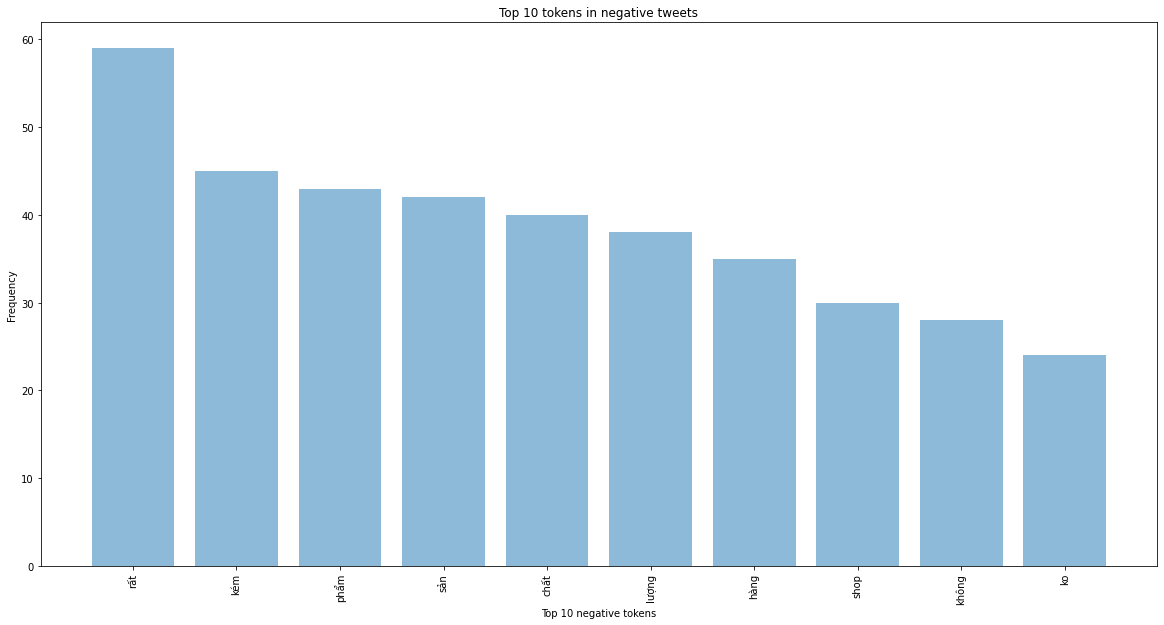

In [12]:
y_pos = np.arange(10)
plt.figure(figsize=(20,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:10], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:10].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 10 negative tokens')
plt.title('Top 10 tokens in negative tweets')

Text(0.5, 1.0, 'Top 100 tokens in slight negative tweets')

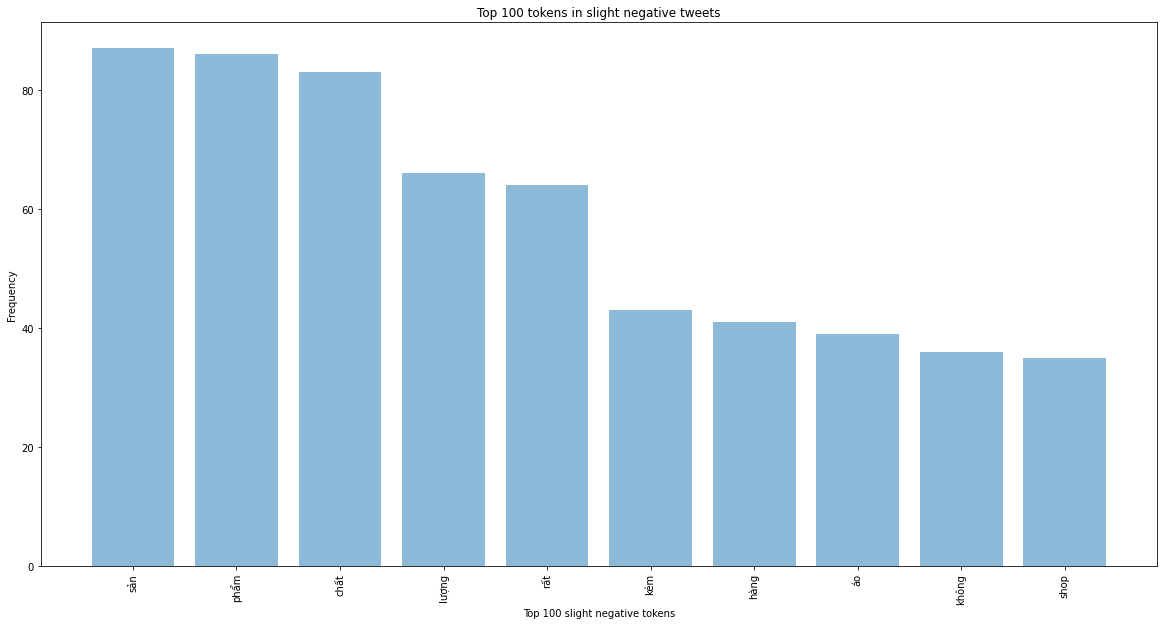

In [13]:
y_pos = np.arange(10)
plt.figure(figsize=(20,10))
plt.bar(y_pos, term_freq_df.sort_values(by='slight_negative', ascending=False)['slight_negative'][:10], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='slight_negative', ascending=False)['slight_negative'][:10].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 100 slight negative tokens')
plt.title('Top 100 tokens in slight negative tweets')

Text(0.5, 1.0, 'Top 100 tokens in neutral tweets')

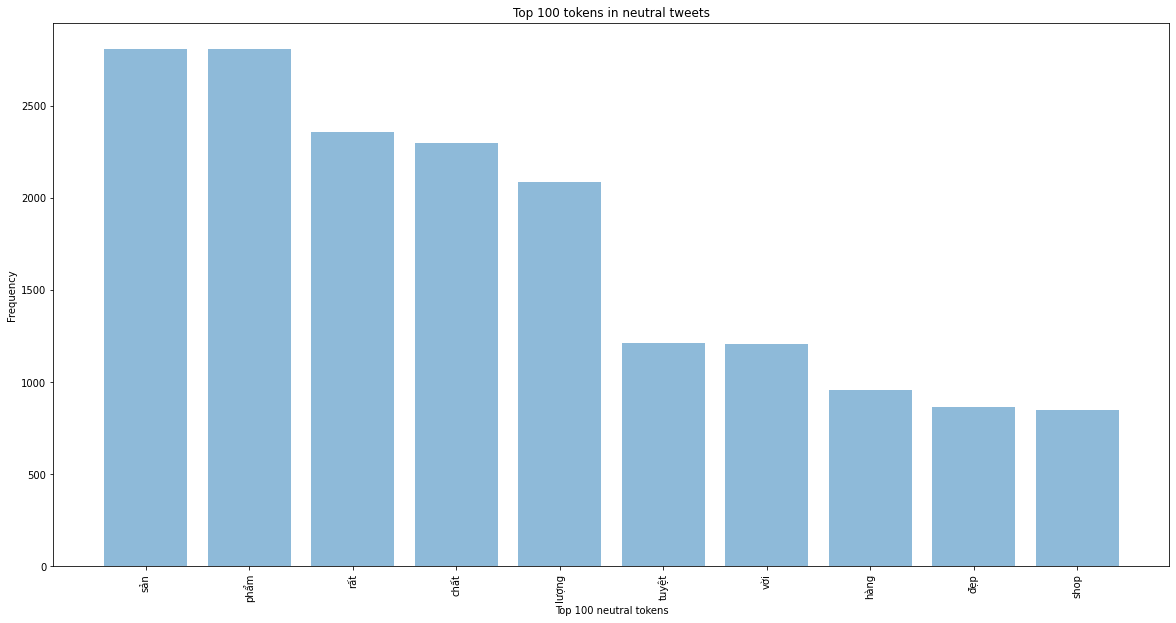

In [14]:
y_pos = np.arange(10)
plt.figure(figsize=(20,10))
plt.bar(y_pos, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:10], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:10].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 100 neutral tokens')
plt.title('Top 100 tokens in neutral tweets')

Text(0.5, 1.0, 'Top 100 tokens in slight_positive tweets')

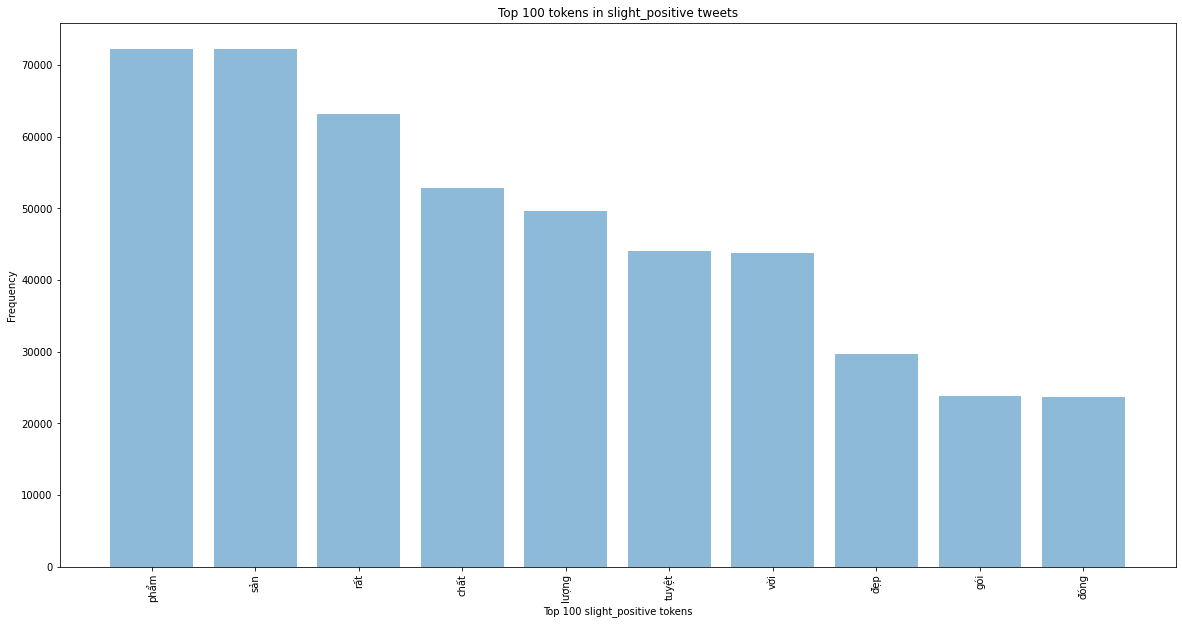

In [15]:
y_pos = np.arange(10)
plt.figure(figsize=(20,10))
plt.bar(y_pos, term_freq_df.sort_values(by='slight_positive', ascending=False)['slight_positive'][:10], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='slight_positive', ascending=False)['slight_positive'][:10].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 100 slight_positive tokens')
plt.title('Top 100 tokens in slight_positive tweets')

Text(0.5, 1.0, 'Top 100 tokens in positive tweets')

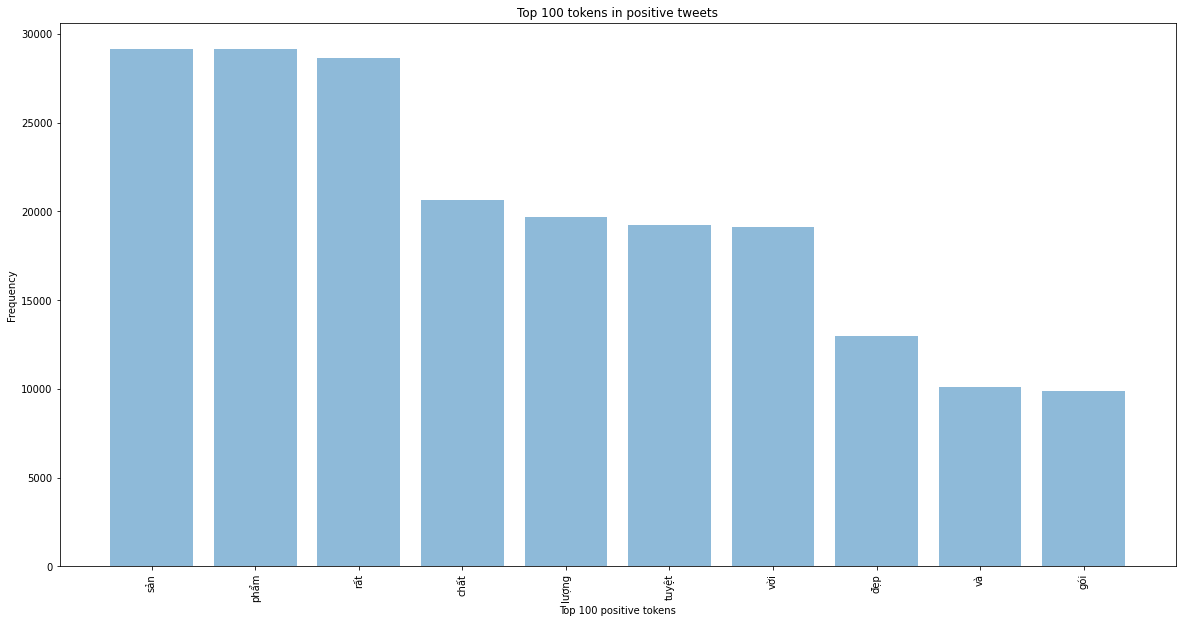

In [16]:
y_pos = np.arange(10)
plt.figure(figsize=(20,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:10], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:10].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 100 positive tokens')
plt.title('Top 100 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

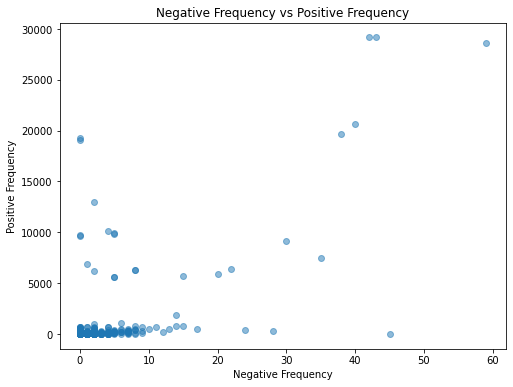

In [85]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

# Model

In [10]:
df = pd.read_csv('tiki_sentiment/preprocessed_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.head(3)

,ttn_gia,ttn_bl_diem,ttn_bl_noi_dung,ttn_thuong_hieu
0,45.000,5,chất lượng sản phẩm tuyệt vời,No Brand
1,255.000,4,"chất lượng sản phẩm tuyệt vời, chất lượng sản ...",No Brand
2,105.000,5,chất lượng sản phẩm tuyệt vời đóng gói sản phẩ...,No Brand


## Baseline

In [107]:
x = df.ttn_bl_noi_dung
y = df.ttn_bl_diem
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print("Train set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(x_train), 
    (len(x_train[y_train == 1]) / (len(x_train)*1.))*100, 
    (len(x_train[y_train == 2]) / (len(x_train)*1.))*100, 
    (len(x_train[y_train == 3]) / (len(x_train)*1.))*100, 
    (len(x_train[y_train == 4]) / (len(x_train)*1.))*100, 
    (len(x_train[y_train == 5]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(x_validation), 
    (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100, 
    (len(x_validation[y_validation == 2]) / (len(x_validation)*1.))*100, 
    (len(x_validation[y_validation == 3]) / (len(x_validation)*1.))*100, 
    (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100, 
    (len(x_validation[y_validation == 5]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(x_test),
    (len(x_test[y_test == 1]) / (len(x_test)*1.))*100,
    (len(x_test[y_test == 2]) / (len(x_test)*1.))*100,
    (len(x_test[y_test == 3]) / (len(x_test)*1.))*100,
    (len(x_test[y_test == 4]) / (len(x_test)*1.))*100,
    (len(x_test[y_test == 5]) / (len(x_test)*1.))*100))

Train set has total 9864 entries with 
 0.85% negative, 0.69% slight negative, 5.38% neutral, 45.19% slight positive, 47.88% positive
Validation set has total 101 entries with 
 2.97% negative, 0.00% slight negative, 2.97% neutral, 41.58% slight positive, 52.48% positive
Test set has total 101 entries with 
 1.98% negative, 0.00% slight negative, 5.94% neutral, 45.54% slight positive, 46.53% positive


If the model predict all are positive, it will get 52.48% accuracy on validation set 


Note that in Base Model there is no slight_negative in both validation and test

=> We are going to apply oversampling to minority classes (negative: 1, slight_negative: 2) and use kfold cross validation

## Count Vectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

cvec = CountVectorizer()
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

In [96]:
def lr_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
            
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('            1            2            3           4           5')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    return np.mean(accuracy)

In [ ]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

original_pipeline = Pipeline([
    ('vectorizer', cvec),
    ('classifier', lr)
])

ROS_pipeline = make_pipeline(cvec, RandomOverSampler(random_state=777),lr)
SMOTE_pipeline = make_pipeline(cvec, SMOTE(random_state=777),lr)
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, original_pipeline, 'macro')


In [ ]:
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')

In [ ]:
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, SMOTE_pipeline, 'macro')


## Oversampling approach
Imbalance data results: (note that there is no sample for slight_negative class)
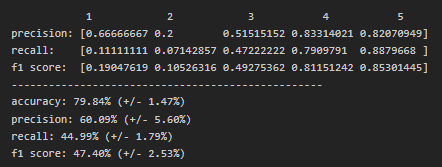
ROS pipeline results: (repeats row of minority class)
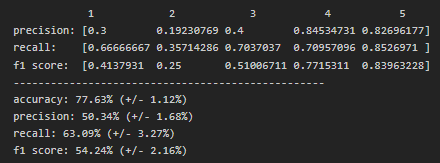
SMOTE pipeline results: (choose random values in each column of 2 rows)
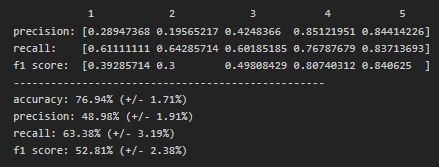

In [23]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
RUS_pipeline = make_pipeline(cvec, RandomUnderSampler(random_state=777),lr)
NM1_pipeline = make_pipeline(cvec, NearMiss(sampling_strategy='not minority', version = 1),lr)
NM2_pipeline = make_pipeline(cvec, NearMiss(sampling_strategy='not minority', version = 2),lr)
NM3_pipeline = make_pipeline(cvec, NearMiss(sampling_strategy='not minority', version = 3, n_neighbors_ver3=4),lr)

In [ ]:
rus = RandomUnderSampler(random_state=777)
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, RUS_pipeline, 'macro')

In [ ]:
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, NM1_pipeline, 'macro')

In [ ]:
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, NM2_pipeline, 'macro')

In [ ]:
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, NM3_pipeline, 'macro')

### Undersampling approach
While this does improve results of minority classes, f1 accuracy of majority classes also drop dramatically

In NM2, the model rarely predicts positive class (recall: 0.13)

RUS result (randomly removing data from the majority class)
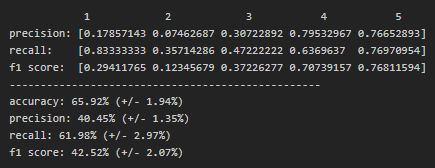
NM1 result
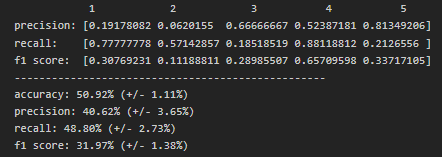
NM2 result
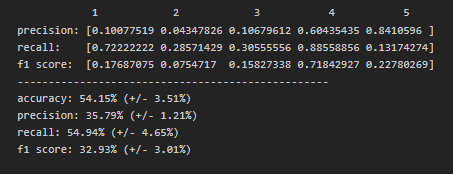
NM3 result
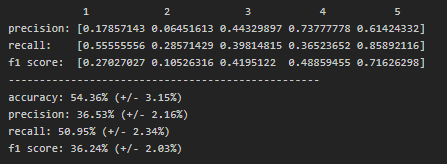

Based on the result, we are going to use ROS pipeline for later use

Result of Count Vectorizer is 77.63%

## Count Vectorizer + N-gams

In [ ]:
cvec.set_params(ngram_range=(1, 2))
ROS_pipeline = make_pipeline(cvec, RandomOverSampler(random_state=777),lr)
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')


In [ ]:
cvec.set_params(ngram_range=(1, 3))
ROS_pipeline = make_pipeline(cvec, RandomOverSampler(random_state=777),lr)
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')

Result:
2-grams:
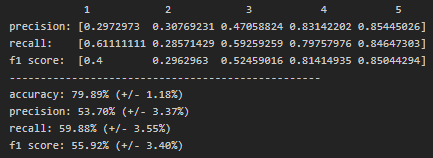
3-grams:
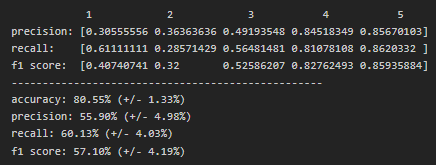

3-grams works best

##  TF-idf

In [ ]:
n_features = np.arange(10000,100001,10000)
result = []
for n in n_features: 
    tvec.set_params(max_features=n, ngram_range=(1, 3))
    ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
    accuracy = lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')
    result.append(accuracy)

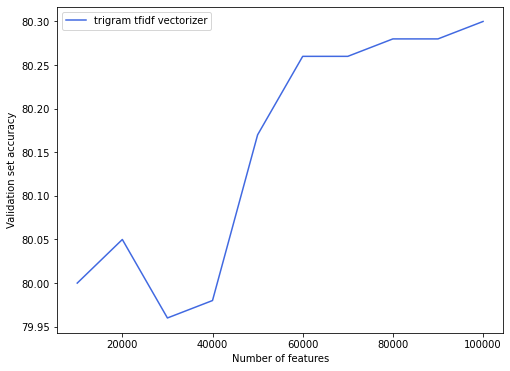

In [43]:
n_features = np.arange(10000,100001,10000)
nfeatures_plot = pd.DataFrame(n_features,columns=['nfeatures'])
nfeatures_plot['validation_accuracy'] = result
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot.nfeatures, nfeatures_plot.validation_accuracy, label='trigram tfidf vectorizer',color='royalblue')
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

So we are going to pick the number of features as: 100.000

Best model currently

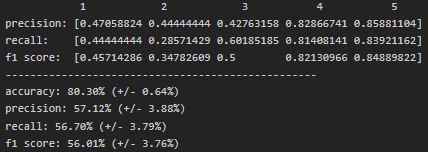

##  TF-idf + Chi2

Let's try to use Chi2 to reduce the number of features

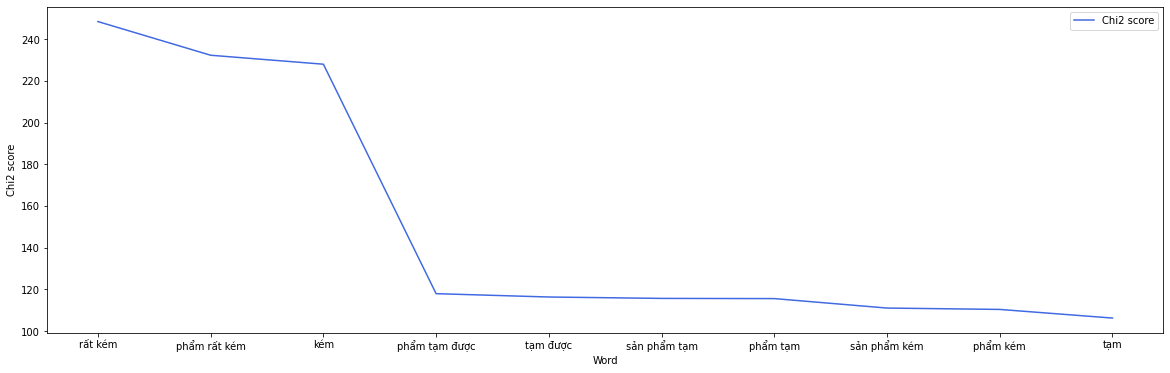

In [64]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

x = df.ttn_bl_noi_dung
y = df.ttn_bl_diem
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_tfidf = tvec.fit_transform(x)
chi2score = chi2(x_tfidf, y)[0]

chi2_df = pd.DataFrame({
    'word': tvec.get_feature_names(),
    'score': chi2score
})
chi2_df = chi2_df.sort_values(by='score', ascending=False)
plt.figure(figsize=(20,6))
plt.plot(chi2_df.word[:10], chi2_df.score[:10], label='Chi2 score',color='royalblue')
plt.xlabel("Word")
plt.ylabel("Chi2 score")
plt.legend()


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
chi2_result = []
n_features = np.arange(10000,100000,10000)
lr = LogisticRegression(max_iter=100)

for n in n_features:
    chi2_tranformer = SelectKBest(chi2, k=n)
    ROS_pipeline = make_pipeline(tvec,chi2_tranformer, RandomOverSampler(random_state=777),lr)
    score = lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')
    chi2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))
    print(score)


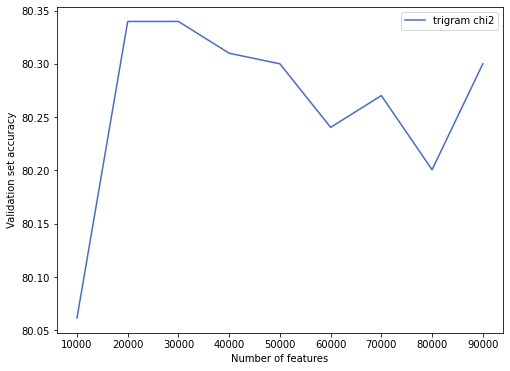

In [142]:
chi2_plot = pd.DataFrame(n_features,columns=['nfeatures'])
chi2_plot['validation_accuracy'] = chi2_result
plt.figure(figsize=(8,6))
plt.plot(chi2_plot.nfeatures, chi2_plot.validation_accuracy, label='trigram chi2',color='royalblue')
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

So we'll pick k=20000 for chi square

In [ ]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
chi2_tranformer = SelectKBest(chi2, k=20000)
lr = LogisticRegression(max_iter=1000)
ROS_pipeline = make_pipeline(tvec,chi2_tranformer, RandomOverSampler(random_state=777),lr)
lr_cv(5, df.ttn_bl_noi_dung, df.ttn_bl_diem, ROS_pipeline, 'macro')

Tfidf + Chi2 result:
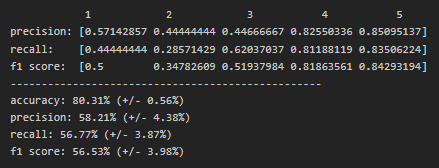

## PhoW2V

In [ ]:
import io

def load_vectors(fname):
    f = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, f.readline().split())
    data = {}
    for line in f:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data
wordvec_df = load_vectors('tiki_sentiment/word2vec_vi_words_300dims.txt') 
wordvec_df

In [ ]:
def normalize_w2v(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec